In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import salem
import nivapy
import numpy
import cartopy
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore") # Ignore warnings for final version of notebook

# Explanatory variables for fish Hg dataset

Hans Fredrik has a dataset summarising Hg in fish for the period from 1965 to 2015 (see e-mail received 03/04/2018 at 09:22 for details). The aim of this notebook is to gather relevant supporting data for further analysis.

Time is tight, so for this the moment I'll focus on calculating averages for each variable of interest for the period from 1965 to 2015 (where data are available). This will mask lots of inter-annual variability, but it also keeps things relatively simple for now.

## 1. Fish dataset

### 1.1. Read raw data

In [2]:
# Read data
in_xlsx = (r'C:\Data\James_Work\Staff\Hans_Fredrik_B\Fish_Hg'
           r'\Fish_Hg_database_per_lake_LRTAP.xlsx')
hg_df = pd.read_excel(in_xlsx)

hg_df.head()

,Lake,Latitude,Longitude,Region,n,Mean Hg OBS,Median Hg OBS,STDEV Hg OBS,Mean mod. Hg,Median mod. Hg,STDEV mod Hg
0,Aakenusjärvi,67.74675,24.49308,3,10,0.057000,0.050000,0.020575,0.199028,0.198727,0.009644
1,Aalisjärvi,67.00000,24.32000,3,40,0.362714,0.319671,0.170330,0.623680,0.597125,0.127672
2,Abbortjennet,60.23000,11.47000,2,20,0.680200,0.665000,0.117467,0.279739,0.278208,0.023163
3,Abbortjernet306,60.01000,12.01000,2,23,0.575130,0.559000,0.155680,0.254368,0.260141,0.036336
4,Ahilammi,60.91077,24.63755,4,35,0.148000,0.130000,0.063236,0.175581,0.176866,0.032014


### 1.2. Interactive map of raw data

In [3]:
# Map of stations
map1 = nivapy.spatial.quickmap(hg_df, 
                               lon_col='Longitude', 
                               lat_col='Latitude', 
                               popup='Lake')
map1

### 1.3. Static map of raw data

These data cover the whole of Fennoscandia (primarily from Finland). For further mapping, it's therefore reasonable to use the Albers Equal Area projection that I created for Leah's DOMQUA DOC work. This is imported below.

In [4]:
# Read "snap raster" in desired projection
tif_path = (r'K:\Prosjekter\Klima\O-13382 DomQua HWI\8 Future DOC'
            r'\GIS\chem_TOC_idw_n24_p1.tif')
gtif = salem.open_xr_dataset(tif_path)

# Adjust gtif co-ords to cell centres
gtif['x'] = gtif['x'] + 12500
gtif['y'] = gtif['y'] - 12500

gtif

<xarray.Dataset>
Dimensions:  (x: 80, y: 80)
Coordinates:
  * y        (y) float64 1.988e+06 1.962e+06 1.938e+06 1.912e+06 1.888e+06 ...
  * x        (x) float64 1.25e+04 3.75e+04 6.25e+04 8.75e+04 1.125e+05 ...
Data variables:
    data     (y, x) float32 2.05386 2.15168 1.89813 1.89878 1.9685 1.96922 ...
Attributes:
    pyproj_srs:  +lon_0=15 +ellps=WGS84 +y_0=1000000 +no_defs=True +proj=aea ...

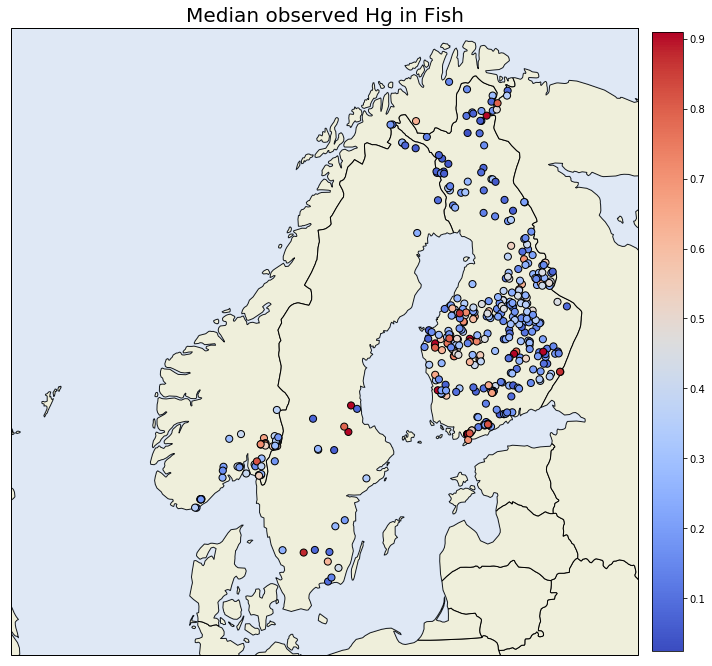

In [5]:
# Define co-ord system
crs = ccrs.AlbersEqualArea(central_longitude=15, 
                           central_latitude=63, 
                           false_easting=1000000, 
                           false_northing=1000000,
                           standard_parallels=(53, 73))  

# Define Natural Earth data
# Land
land_50m = cfeature.NaturalEarthFeature(category='cultural',
                                        name='admin_0_countries', 
                                        scale='50m',
                                        edgecolor='black',
                                        facecolor=cfeature.COLORS['land'])
# Sea
sea_50m = cfeature.NaturalEarthFeature(category='physical',
                                       name='ocean',
                                       scale='50m',
                                       edgecolor='none',
                                       facecolor=cfeature.COLORS['water'],
                                       alpha=0.3)

# Plot data
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent([0, 2000000, 0, 2000000], crs=crs)

# Add geo data
ax.add_feature(land_50m)
ax.add_feature(sea_50m)

# Set max value for colour ramp at 95th percentile
pct = hg_df['Median Hg OBS'].describe(percentiles=[0.95,]).ix['95%']


# Add points using linear colour ramp from 0 to vmax_pct   
cax = ax.scatter(hg_df['Longitude'].values, 
           hg_df['Latitude'].values, 
           c=hg_df['Median Hg OBS'].values, 
           cmap='coolwarm', 
           vmax=pct, 
           s=50, 
           zorder=5,
           edgecolors='k', 
           transform=ccrs.PlateCarree())
cbar = fig.colorbar(cax, fraction=0.046, pad=0.02)

# Title
ax.set_title('Median observed Hg in Fish', fontsize=20)
plt.tight_layout()

## 2. E-Obs elevation data

A 0.25 degree (i.e. approximately 25 km at the equator) resolution elevation dataset is available from E-Obs ([here](https://www.ecad.eu/download/ensembles/download.php)). This is quite coarse, and much of the topographic variation will be smoothed with this level of aggregation. However, Hans Fredrik would like approximate elevations for the lakes, and this is the best elevation dataset for the whole of Fennoscandia that I have easily available.

In [6]:
# Read elevation data
nc_path = (r'C:\Data\James_Work\Staff\Hans_Fredrik_B\Fish_Hg\data'
           r'\elevation\elev_0.25deg_reg_v16.0.nc')
elev_ds = xr.open_dataset(nc_path)
elev_ds

<xarray.Dataset>
Dimensions:    (latitude: 201, longitude: 464)
Coordinates:
  * longitude  (longitude) float32 -40.375 -40.125 -39.875 -39.625 -39.375 ...
  * latitude   (latitude) float32 25.375 25.625 25.875 26.125 26.375 26.625 ...
Data variables:
    elevation  (latitude, longitude) float32 ...
Attributes:
    Ensembles_ECAD:  16.0
    Conventions:     CF-1.4
    References:      http://www.ecad.eu\nhttp://www.ecad.eu/download/ensemble...

### 2.1. Map of elevations

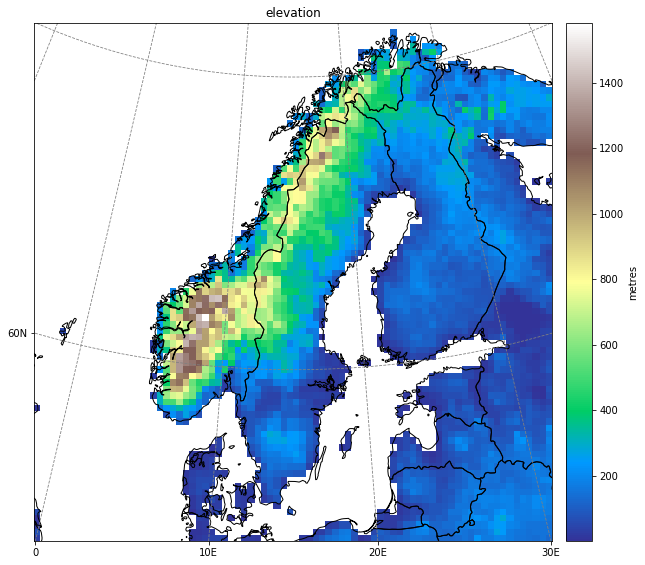

In [19]:
# Reproject (and clip) to desired CRS
elev_ds_proj = gtif.salem.transform(elev_ds, interp='nearest')

# Plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
elev_ds_proj['elevation'].salem.quick_map(ax=ax, cmap='terrain')

### 2.2. Extract elevation values for point locations

In [8]:
# Extract elevation data
dsloc = elev_ds.sel_points(longitude=hg_df['Longitude'].values,
                           latitude=hg_df['Latitude'].values,
                           method='nearest')

# Convert to df
elev_df =  dsloc['elevation'].to_dataframe()

# Append to original df
hg_df['elev_m'] = elev_df['elevation'].round(1)

hg_df.head()

,Lake,Latitude,Longitude,Region,n,Mean Hg OBS,Median Hg OBS,STDEV Hg OBS,Mean mod. Hg,Median mod. Hg,STDEV mod Hg,elev_m
0,Aakenusjärvi,67.74675,24.49308,3,10,0.057000,0.050000,0.020575,0.199028,0.198727,0.009644,280.700012
1,Aalisjärvi,67.00000,24.32000,3,40,0.362714,0.319671,0.170330,0.623680,0.597125,0.127672,211.399994
2,Abbortjennet,60.23000,11.47000,2,20,0.680200,0.665000,0.117467,0.279739,0.278208,0.023163,184.199997
3,Abbortjernet306,60.01000,12.01000,2,23,0.575130,0.559000,0.155680,0.254368,0.260141,0.036336,253.600006
4,Ahilammi,60.91077,24.63755,4,35,0.148000,0.130000,0.063236,0.175581,0.176866,0.032014,100.699997


## 3. E-Obs historic climate data

E-Obs also provide historic climate and precipitation data from 1950 to mid-2017.

### 3.1. Annual averages (1965 to 2015)

The code below calculates annual average temperature and total precipitation for the period from 1965 to 2015.

In [9]:
# Read all the historic files and combine into a single dataset
nc_path = (r'C:\Data\James_Work\Staff\Hans_Fredrik_B\Fish_Hg\data\climate\*.nc')
ds_obs = xr.open_mfdataset(nc_path)

# Get variable info without reading whole dataset
ds_obs.variables

Frozen(OrderedDict([(u'longitude', <xarray.IndexVariable u'longitude' (longitude: 464)>
array([-40.375, -40.125, -39.875, ...,  74.875,  75.125,  75.375], dtype=float32)
Attributes:
    long_name:      Longitude values
    units:          degrees_east
    standard_name:  longitude), (u'latitude', <xarray.IndexVariable u'latitude' (latitude: 201)>
array([ 25.375,  25.625,  25.875, ...,  74.875,  75.125,  75.375], dtype=float32)
Attributes:
    long_name:      Latitude values
    units:          degrees_north
    standard_name:  latitude), (u'time', <xarray.IndexVariable u'time' (time: 24715)>
array(['1950-01-01T00:00:00.000000000', '1950-01-02T00:00:00.000000000',
       '1950-01-03T00:00:00.000000000', ..., '2017-08-29T00:00:00.000000000',
       '2017-08-30T00:00:00.000000000', '2017-08-31T00:00:00.000000000'], dtype='datetime64[ns]')
Attributes:
    long_name:      Time in days
    standard_name:  time), (u'rr', <xarray.Variable (time: 24715, latitude: 201, longitude: 464)>
dask.arra

In [10]:
# Get only data from 1965 to 2015
ds_obs = ds_obs.sel(time=slice('1965-01-01', '2015-12-31'))

# Calculate mean annual temperature
ds_obst = ds_obs['tg'].resample(freq='A',
                                dim='time', 
                                how='mean')

# Calculate sum annual pptn
ds_obsp = ds_obs['rr'].resample(freq='A',
                                dim='time', 
                                how='sum',
                                skipna=False)

# Combine temp and pptn
ds_obs = xr.merge([ds_obst, ds_obsp])

# Average over years
ds_obs = ds_obs.mean(dim='time')

ds_obs

<xarray.Dataset>
Dimensions:    (latitude: 201, longitude: 464)
Coordinates:
  * longitude  (longitude) float32 -40.375 -40.125 -39.875 -39.625 -39.375 ...
  * latitude   (latitude) float32 25.375 25.625 25.875 26.125 26.375 26.625 ...
Data variables:
    tg         (latitude, longitude) float32 dask.array<shape=(201, 464), chunksize=(201, 464)>
    rr         (latitude, longitude) float32 dask.array<shape=(201, 464), chunksize=(201, 464)>

### 3.2. Map historic climate

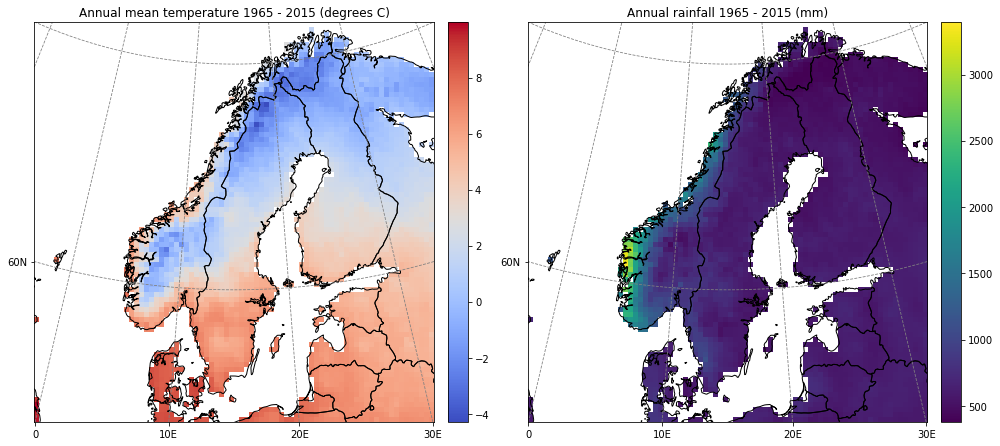

In [11]:
# Reproject (and clip) to desired CRS
ds_obs_proj = gtif.salem.transform(ds_obs, interp='nearest')

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

ds_obs_proj['tg'].salem.quick_map(ax=axes[0], cmap='coolwarm')
ds_obs_proj['rr'].salem.quick_map(ax=axes[1])

axes[0].set_title('Annual mean temperature 1965 - 2015 (degrees C)')
axes[1].set_title('Annual rainfall 1965 - 2015 (mm)')

plt.tight_layout()

### 3.3. Extract climate data for points

In [12]:
# Extract elevation data
dsloc = ds_obs.sel_points(longitude=hg_df['Longitude'].values,
                          latitude=hg_df['Latitude'].values,
                          method='nearest')

# Convert to df
clim_df =  dsloc.to_dataframe()

# Append to original df
hg_df['avg_ann_rain_mm'] = clim_df['rr'].round(1)
hg_df['avg_ann_temp_C'] = clim_df['tg'].round(1)

hg_df.head()

,Lake,Latitude,Longitude,Region,n,Mean Hg OBS,Median Hg OBS,STDEV Hg OBS,Mean mod. Hg,Median mod. Hg,STDEV mod Hg,elev_m,avg_ann_rain_mm,avg_ann_temp_C
0,Aakenusjärvi,67.74675,24.49308,3,10,0.057000,0.050000,0.020575,0.199028,0.198727,0.009644,280.700012,525.000000,-0.8
1,Aalisjärvi,67.00000,24.32000,3,40,0.362714,0.319671,0.170330,0.623680,0.597125,0.127672,211.399994,539.400024,-0.2
2,Abbortjennet,60.23000,11.47000,2,20,0.680200,0.665000,0.117467,0.279739,0.278208,0.023163,184.199997,818.700012,4.8
3,Abbortjernet306,60.01000,12.01000,2,23,0.575130,0.559000,0.155680,0.254368,0.260141,0.036336,253.600006,840.500000,4.2
4,Ahilammi,60.91077,24.63755,4,35,0.148000,0.130000,0.063236,0.175581,0.176866,0.032014,100.699997,576.799988,4.4


## 4. EMEP deposition data

For the DOMQUA project, Leah obtained simulated N and S deposition data from EMEP. I have added these data to a single Excel file.

### 4.1. Read and process raw deposition data

In [13]:
# Read dep data
in_xlsx = (r'C:\Data\James_Work\Staff\Hans_Fredrik_B\Fish_Hg\data'
           r'\deposition\domqua_emep_deposition.xlsx')
n_dep_df = pd.read_excel(in_xlsx, sheetname='n_dep')
s_dep_df = pd.read_excel(in_xlsx, sheetname='s_dep')

# Get just data for years between 1965 and 2015
years = range(1965, 2015, 5)
cols = ['Lat', 'Lon'] + years
n_dep_df = n_dep_df[cols]
s_dep_df = s_dep_df[cols]

# Calc N averages for each row
n_dep_df.set_index(['Lat', 'Lon'], inplace=True)
n_dep_df = n_dep_df.mean(axis=1)
n_dep_df.name = 'n_dep_mgN/m2/yr'
n_dep_df = n_dep_df.reset_index()

# Calc N averages for each row
s_dep_df.set_index(['Lat', 'Lon'], inplace=True)
s_dep_df = s_dep_df.mean(axis=1)
s_dep_df.name = 's_dep_mgS/m2/yr'
s_dep_df = s_dep_df.reset_index()

# Join 
dep_df = pd.merge(n_dep_df, s_dep_df, 
                  on=['Lat', 'Lon'], 
                  how='outer')

assert len(dep_df) == len(n_dep_df)

dep_df.head()

,Lat,Lon,n_dep_mgN/m2/yr,s_dep_mgS/m2/yr
0,54.0,7.5,589.48,2225.09
1,54.0,8.5,674.00,2493.26
2,54.0,9.0,764.07,2679.46
3,54.0,9.5,810.64,2975.13
4,54.0,10.0,797.52,2967.76


### 4.2. Map of long-term deposition

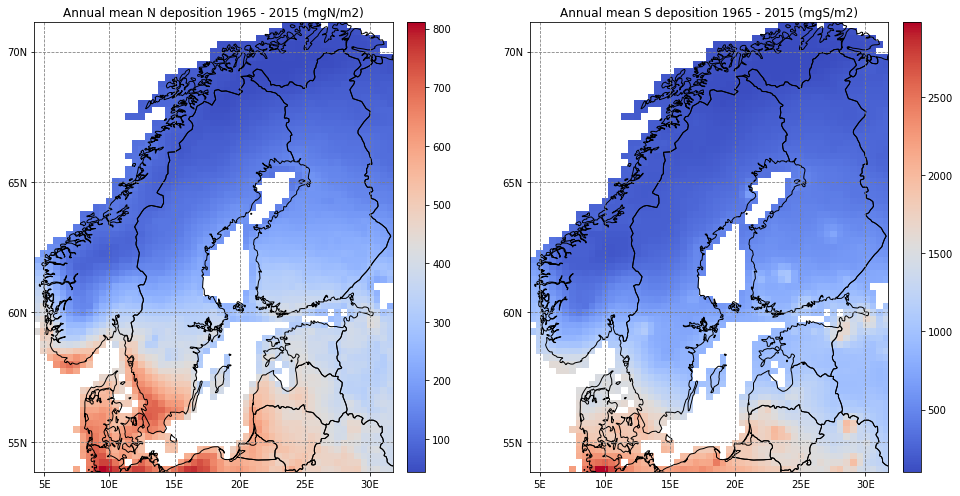

In [14]:
# Convert to xarray dataset
dep_df.set_index(['Lat', 'Lon'], inplace=True)
dep_ds = xr.Dataset.from_dataframe(dep_df)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

dep_ds['n_dep_mgN/m2/yr'].salem.quick_map(ax=axes[0], cmap='coolwarm')
dep_ds['s_dep_mgS/m2/yr'].salem.quick_map(ax=axes[1], cmap='coolwarm')

axes[0].set_title('Annual mean N deposition 1965 - 2015 (mgN/m2)')
axes[1].set_title('Annual mean S deposition 1965 - 2015 (mgS/m2)')

plt.tight_layout()

### 4.3. Extract deposition data for points

In [15]:
# Extract elevation data
dsloc = dep_ds.sel_points(Lon=hg_df['Longitude'].values,
                          Lat=hg_df['Latitude'].values,
                          method='nearest')

# Convert to df
dep_df =  dsloc.to_dataframe()

# Append to original df
hg_df['avg_ann_N_dep_mgN/m2'] = dep_df['n_dep_mgN/m2/yr'].round(1)
hg_df['avg_ann_S_dep_mgS/m2'] = dep_df['s_dep_mgS/m2/yr'].round(1)

hg_df.head()

,Lake,Latitude,Longitude,Region,n,Mean Hg OBS,Median Hg OBS,STDEV Hg OBS,Mean mod. Hg,Median mod. Hg,STDEV mod Hg,elev_m,avg_ann_rain_mm,avg_ann_temp_C,avg_ann_N_dep_mgN/m2,avg_ann_S_dep_mgS/m2
0,Aakenusjärvi,67.74675,24.49308,3,10,0.057000,0.050000,0.020575,0.199028,0.198727,0.009644,280.700012,525.000000,-0.8,88.3,232.3
1,Aalisjärvi,67.00000,24.32000,3,40,0.362714,0.319671,0.170330,0.623680,0.597125,0.127672,211.399994,539.400024,-0.2,110.6,271.5
2,Abbortjennet,60.23000,11.47000,2,20,0.680200,0.665000,0.117467,0.279739,0.278208,0.023163,184.199997,818.700012,4.8,298.6,700.4
3,Abbortjernet306,60.01000,12.01000,2,23,0.575130,0.559000,0.155680,0.254368,0.260141,0.036336,253.600006,840.500000,4.2,328.2,770.0
4,Ahilammi,60.91077,24.63755,4,35,0.148000,0.130000,0.063236,0.175581,0.176866,0.032014,100.699997,576.799988,4.4,339.9,789.6
